### Battery Dev Challenge 1
## Team 'Code Better'
The goal of this challenge is to predict future battery State-of-Health (SOH), using features extracted from the raw current, voltage, temperature, and time data (I-V-T-t data).
The provided data is very small: 6 months of data from one cell, running a repeating drive cycle. The SOH metric used as the target data (training and test data, i.e., the y-variable) is the discharge capacity from a defined check-up procedure.

| X data | Y data|
| ---- | ---- |
| 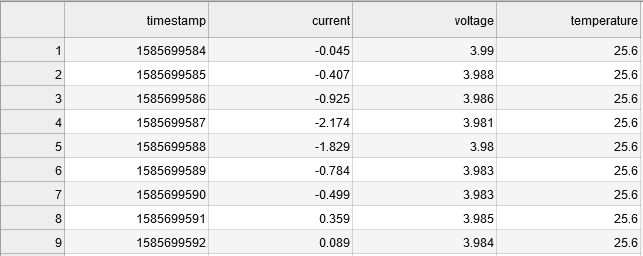 | 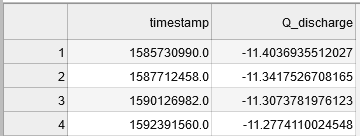 |
| 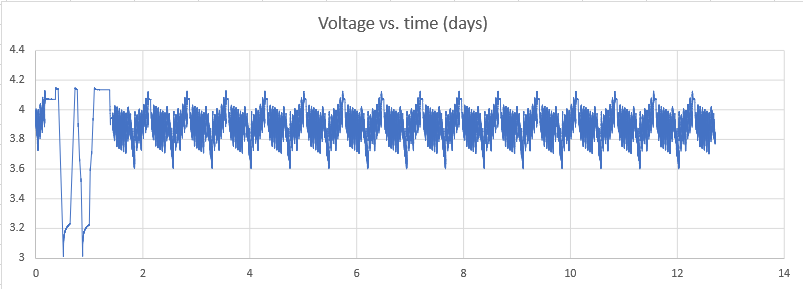 | 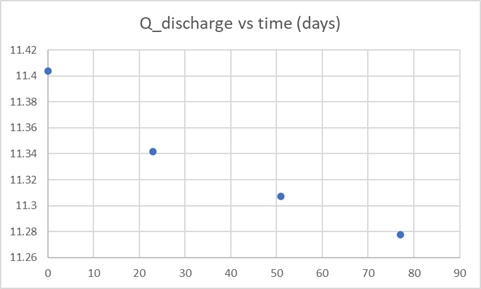 |

Based on the extremely limited amount of data, no rigorous machine-learning model should be made to map raw data features to capacity; there is only enough target data (4 data points) to make a simple extrapolation forwards in time. There are many features that could be extracted from the raw data, for instance, every charge cycle; there are many charges throughout the drive cycle, replicating the bus recharging at stops, and though these charges differ in their duration and SOC windows, they could likely be used as input to various machine-learning methods. However, these charges would need to be trained on synthetic target data, which could be generated by fitting a simple model to the provided target data, such as a polynomial interpolation. But this approach would just learn the behavior of the model used to generate the synthetic data.

So, for the challenge, just a simple power law model will be used to extrapolate the training data to future times:
$Q = Q_0 - amp*t^{power}$

The goal of this team was to use best-practices for version control, data management, and reproducibility of the data handling and model development workflow. To that aim, several different tools were used:
 - Docker
     - Docker enables reproducibility of the OS, software, and versions used.
     - Docker is used by various development tools, as well, such as ndbev.
     - https://hub.docker.com/
 - Github
     - Github perhaps needs no introduction, but it enables version control and change history for files and folders
 - DVC
     - DVC, short for Data Version Control, tracks data files and the entire data manipulation and model identification process, as well as a change history. Because every stage of the data modification and model identification must be exactly specified in DVC, and all changes to this process are saved, DVC empowers reproducibility and comparison between versions. DVC also has tools enabling rapid experimentation.
     - https://dvc.org/

For instance, DVC can be used to easily generate a dependency map of the entire data manipulation and model identification workflow using the command 'dvc dag' in the terminal window.
In this case, the map is extremely simple - raw data files were concatenated, and then a simple power law model was fit to the target data.

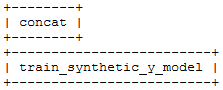

DVC stores the project pipeline in the dvc.yaml file, and any changes to this file will be tracked by Github, so that way the entire history of the model development process is stored. Model development stages are added to the dvc.yaml file by running the stage using the terminal command 'dvc run', specifying exactly what input data files will be read, the code to be run, and the output files generated. This seems like a lot of overhead, but in practice, it requires user to be more thoughtful about their experimentation, empowers exact reproducibility, and allows for DVC to automate the model pipeline, which dramatically speeds up future experiments.

Future work will demonstrate a more complex machine learning workflow in DVC, extracting features from the raw I-V-T-t data and training a model using synthetic target data; however, note that this approach is inherently overfitting the data, as we would be training a model on a model.

### Model predictions
Import dependencies.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load the parameters fit by the model in 'stages/identify_synthetic_y_model.py'

In [2]:
params = pd.read_csv('../models/params.txt', names=['amp','power'])
params

,amp,power
0,0.000394,0.594263


Load the target data to test the model on, and add some new variables for readability:

In [3]:
df_y = pd.read_csv('../data/target.csv')
df_y['t_days'] = (df_y.timestamp-df_y.timestamp[0])/(24*3600)
df_y['Q'] = np.abs(df_y.Q_discharge)
df_y

,timestamp,Q_discharge,t_days,Q
0,1.585731e+09,-11.403694,0.000000,11.403694
1,1.587712e+09,-11.341753,22.933657,11.341753
2,1.590127e+09,-11.307378,50.879537,11.307378
3,1.592392e+09,-11.277411,77.089931,11.277411


Define the model:

In [4]:
Q0 = df_y.Q[0]
def capacity_fade_model(t):
    amp = params.amp.values
    power = params.power.values
    return np.array(Q0 - (amp*t)**power)

Test on the target data and calculate some statistics:

In [5]:
y_test = capacity_fade_model(df_y.t_days)
y_test

array([11.40369355, 11.34267042, 11.30571049, 11.27826731])

In [6]:
def rmse(y_pred):
    mse = np.sum((df_y.Q - y_pred)**2)/len(df_y.Q)
    return np.sqrt(mse)

rmse(y_test)

0.0010436420034790163

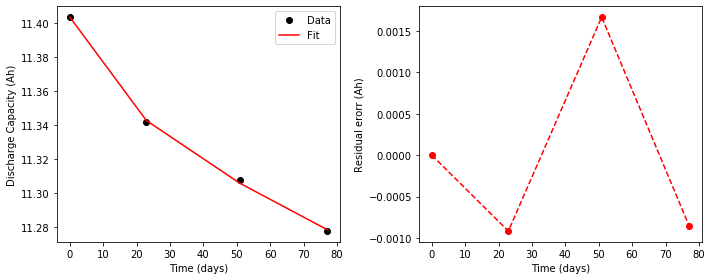

In [7]:
fig, axes = plt.subplots(1,2, figsize=[10, 4])
axes[0].plot(df_y.t_days, df_y.Q, 'ok')
axes[0].plot(df_y.t_days, y_test, '-r')
axes[0].set_xlabel('Time (days)')
axes[0].set_ylabel('Discharge Capacity (Ah)')
axes[0].legend(['Data', 'Fit'])

axes[1].plot(df_y.t_days, df_y.Q - y_test, '--or')
axes[1].set_xlabel('Time (days)')
axes[1].set_ylabel('Residual erorr (Ah)')

plt.tight_layout()

Based on the information we have, this is a good fit. There is not evidence of systemtatic error, though with only 4 data points, that extremely hard to judge. The power of the model, 0.5942, is consistent with an SEI growth dominated degradation mode, which is very common.

The specific task for this model is to estimate the remaining capacity at the following dates:
- 2020-07-11
- 2020-08-04
- 2020-08-28
- 2020-09-22
- 2020-10-01

The data starts on April 1st, 2020, so we should calculate the number of days passed for each date, and then calculate our predictions:

In [8]:
from datetime import date
start_date = date(2020, 4, 1)
t_days_extrap = np.array([(date(2020, 7, 11)-start_date).days,
                 (date(2020, 8, 4)-start_date).days,
                 (date(2020, 8, 28)-start_date).days,
                 (date(2020, 9, 22)-start_date).days,
                 (date(2020, 10, 1)-start_date).days])
t_days_extrap

array([101, 125, 149, 174, 183])

In [9]:
y_extrap = capacity_fade_model(t_days_extrap)
y_extrap

array([11.25642516, 11.23653387, 11.21814409, 11.20022794, 11.19403795])

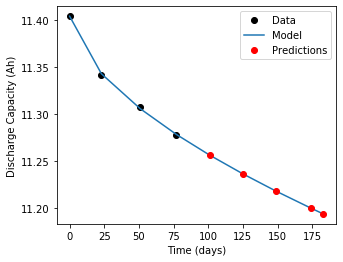

In [10]:
# Combine the training and test data to make a nice line:
t_pred = np.concatenate((df_y.t_days,t_days_extrap))
y_pred = np.concatenate((y_test,y_extrap))

fig, ax = plt.subplots(1,1, figsize=[5, 4])
ax.plot(df_y.t_days, df_y.Q, 'ok')
ax.plot(t_pred, y_pred)
ax.plot(t_days_extrap, y_extrap, 'or')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Discharge Capacity (Ah)')
ax.legend(['Data', 'Model', 'Predictions'])

Results were manually exported into the required .csv format - copying and pasting is a valid tool when there's only 9 data points!

In [11]:
y_pred

array([11.40369355, 11.34267042, 11.30571049, 11.27826731, 11.25642516,
       11.23653387, 11.21814409, 11.20022794, 11.19403795])